In [1]:
%matplotlib inline
import os
import os.path
import cv2
import glob
import imutils
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

- HSV即色相、饱和度、明度（英语：Hue, Saturation, Value

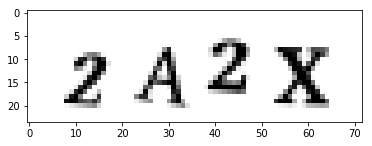

In [95]:
image = cv2.imread("2A2X.png")
plt.imshow(image)
#轉換顏色空間
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
gray = cv2.copyMakeBorder(gray, 8, 8, 8, 8, cv2.BORDER_REPLICATE)
#thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_OTSU|cv2.THRESH_BINARY_INV)[1]
thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_OTSU)[1]

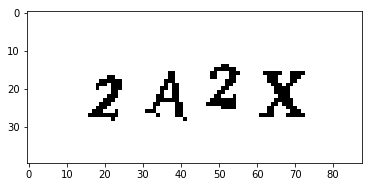

In [96]:
save_path = os.path.join("C:\\Users\\MLUSER\\Documents\\GitHub")
p = os.path.join(save_path, "2A2X.png")
cv2.imwrite(p, thresh)
image = cv2.imread("C:\\Users\\MLUSER\\Documents\\GitHub\\2A2X.png")
plt.imshow(image)

cv2.copyMakeBorder(gray, 8, 8, 8, 8, cv2.BORDER_REPLICATE)
- BORDER_CONSTANT: 使用常数填充边界 (i.e. 黑色或者 0)
- BORDER_REPLICATE: 复制原图中最临近的行或者列。

 http://monkeycoding.com/?p=600
 
 threshold(InputArray src, OutputArray dst, double thresh, double maxval, int type)

src：輸入圖，只能輸入單通道，8位元或32位元浮點數影像。

dst：輸出圖，尺寸大小、深度會和輸入圖相同。

thresh：閾值。

maxval：二值化結果的最大值。

type：二值化操作型態，共有THRESH_BINARY、THRESH_BINARY_INV、THRESH_TRUNC、THRESH_TOZERO、THRESH_TOZERO_INV五種。

type從上述五種結合CV_THRESH_OTSU，類似寫成：THRESH_BINARY | CV_THRESH_OTSU

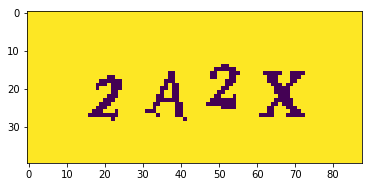

In [87]:
#thresh = cv2.threshold(gray, 0, 255,  cv2.THRESH_OTSU)[1]
#print (thresh[1])
#plt.imshow(thresh)

In [97]:
# find the contours (continuous blobs of pixels) the image
contours = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
print (contours)
# Hack for compatibility with different OpenCV versions
contours = contours[0] if imutils.is_cv2() else contours[1]

save_path = os.path.join("C:\\Users\\MLUSER\\Documents\\GitHub")
p = os.path.join(save_path, "2A2X.png")
cv2.imwrite(p,contours)
image = cv2.imread("C:\\Users\\MLUSER\\Documents\\GitHub\\2A2X.png")
plt.imshow(image)

letter_image_regions = []

(array([[  0,   0,   0, ...,   0,   0,   0],
       [  0,   2,   2, ...,   2, 130,   0],
       [  0,   2,   1, ...,   1, 130,   0],
       ..., 
       [  0,   2,   1, ...,   1, 130,   0],
       [  0,   2,   2, ...,   2, 130,   0],
       [  0,   0,   0, ...,   0,   0,   0]], dtype=uint8), [array([[[ 1,  1]],

       [[ 1, 38]],

       [[86, 38]],

       [[86,  1]]], dtype=int32)], array([[[-1, -1, -1, -1]]], dtype=int32))


TypeError: img is not a numpy array, neither a scalar

In [98]:
for contour in contours:
        # Get the rectangle that contains the contour
    (x, y, w, h) = cv2.boundingRect(contour)

        # Compare the width and height of the contour to detect letters that
        # are conjoined into one chunk
    if w / h > 1.25:
            # This contour is too wide to be a single letter!
            # Split it in half into two letter regions!
        half_width = int(w / 2)
        letter_image_regions.append((x, y, half_width, h))
        letter_image_regions.append((x + half_width, y, half_width, h))
    else:
            # This is a normal letter by itself
        letter_image_regions.append((x, y, w, h))

    # If we found more or less than 4 letters in the captcha, our letter extraction
    # didn't work correcly. Skip the image instead of saving bad training data!
if len(letter_image_regions) != 4:
    pass
    # Sort the detected letter images based on the x coordinate to make sure
    # we are processing them from left-to-right so we match the right image
    # with the right letter
letter_image_regions = sorted(letter_image_regions, key=lambda x: x[0])

In [ ]:
plt.imshow(letter_image_regions)